# Todo

- Get the Swin Transformer to work
- Solve the huggine face problem at jeremy's notebook

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.data.transforms import get_image_files

comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm==0.6.13"')
from fastai.vision.all import *
set_seed(42)

tst_files = get_image_files(path/'test_images').sorted()

In [5]:
path = '/kaggle/input/paddy-disease-classification'
train_path = path+'/train_images'
test_path = path+'/test_images'

In [6]:
from fastai.vision.all import *

In [7]:
train_csv = pd.read_csv(path+'/train.csv')
train_csv.label.value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

(480, 640)


<Axes: >

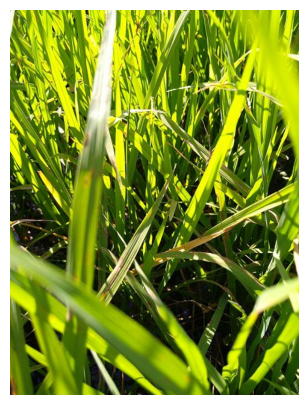

In [8]:
img = PILImage.create(path+'/train_images/blast/100004.jpg')
print(img.size)
img.show()

In [9]:
test_files = get_image_files(path+'/test_images').sorted()

In [ ]:
# No need for that since there is already another one in the method
# This is the first gen, visual lerner; later i turn it to a function

dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=0.2, # Percent perserved for validation
    seed=42,
    item_tfms=Resize((320,240)))


# Zooming in (cropping) to reach the desired size
#     batch_tfms=aug_transforms(size=128, min_scale=0.75)


dls.show_batch(max_n=6)

In [34]:
# This one is second generation visual learner (wrapper?) function, which are not going to use for
# ensembling.

def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(train_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [10]:
# Third gen learner function that is used for ensembling predictions from big models.

def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=12):
    """
    There are many arguments, most are familiar like architecture, size, resizing.
    Other need a bit of explaining like finetune is used to tell the different fit_one_cycle
    and finetuning the model. Accum is the division factor for batch size which is normally
    64, if accum is 2 than we divide by 2.
    """
    
    # Warning normally we would use train_path but these ensemble models are just for ensembling
    # and because of that we can use just one subset of data
    dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)
    
    # Callback
    cbs = GradientAccumulation(64) if accum else []
    
    # Core model
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    
    if finetune:
        learn.fine_tune(epochs, 0.01)
        return learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [11]:
# Function to see how much GPU we used
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()
    
report_gpu()

GPU:0
no processes are running


In [10]:
# conext22 = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate, path='.').to_fp16()

bacterial_path = path + '/train_images/bacterial_panicle_blight'
# If you want to test the GPU usage you can use bacterial path data.

arch = 'convnext_tiny_in22k'
train('convnext_small_in22k', 128, epochs=1, accum=1, finetune=False)

# Trying the compare batch size of half
train('convnext_small_in22k', 128, epochs=1, accum=2, finetune=False)
report_gpu()

From 4083 MB to 3017 MB, not about 25 percent reduction for 50 percent reduction in batch size

In [24]:
train('convnext_small_in22k', 128, epochs=1, accum=4, finetune=False)
report_gpu()

# 3017 now, drops to 2499 which is about 18 percent for another 50 percent in batch size, law of diminishing returns I guess.

report_gpu()

# Can we use size 64 for ConvNext batch size?
train('convnext_large_in22k', (320,240), epochs=1, accum=2, finetune=False)

# Update WE CAN NOT. batch size of 32 barely works.

report_gpu()

train('vit_large_patch16_224', 224, epochs=1, accum=2, finetune=False)
report_gpu()

train('swinv2_large_window12_192_22k', 192, epochs=1, accum=2, finetune=False)
report_gpu()

train('swin_large_patch4_window7_224', 224, epochs=1, accum=2, finetune=False)
report_gpu()

In [12]:
res = 640,480

models = {
    'convnext_large_in22k': {
        (Resize(res), (320,224)),
    }, 'vit_large_patch16_224': {
        (Resize(480, method='squish'), 224),
        (Resize(res), 224),
    }, 'swinv2_large_window12_192_22k': {
        (Resize(480, method='squish'), 192),
        (Resize(res), 192),
    }, 'swin_large_patch4_window7_224': {
        (Resize(res), 224),
    }
}

In [13]:
train_path = path+'/train_images'

In [14]:
tta_res = []

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        tta_res.append(train(arch, size, item=item, accum=2, epochs=1))
        gc.collect()
        torch.cuda.empty_cache()

--- convnext_large_in22k
(320, 224)
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.861438,0.614016,0.182124,18:01


epoch,train_loss,valid_loss,error_rate,time
0,0.435549,0.216560,0.070159,19:52


--- vit_large_patch16_224
224
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,0.970994,0.559280,0.173474,06:28


epoch,train_loss,valid_loss,error_rate,time
0,0.443392,0.249940,0.077847,08:54


--- vit_large_patch16_224
224
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,0.975245,0.575583,0.175877,06:30


epoch,train_loss,valid_loss,error_rate,time
0,0.387153,0.240678,0.081211,08:57


--- swinv2_large_window12_192_22k
192
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.918815,0.656013,0.202787,04:28


epoch,train_loss,valid_loss,error_rate,time
0,0.440427,0.237462,0.078328,05:44


--- swinv2_large_window12_192_22k
192
Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


epoch,train_loss,valid_loss,error_rate,time
0,0.863385,0.489625,0.157136,04:28


epoch,train_loss,valid_loss,error_rate,time
0,0.448489,0.250036,0.074483,05:42


--- swin_large_patch4_window7_224
224
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.940620,0.591349,0.180682,04:33


epoch,train_loss,valid_loss,error_rate,time
0,0.434009,0.258916,0.085055,06:01


In [15]:
# Getting the pred for the ensemble

# Saving
save_pickle('tta_res.pkl', tta_res)

tta_prs = first(zip(*tta_res))

avg_pr = torch.stack(tta_prs).mean(0)
avg_pr.shape

dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

idxs = avg_pr.argmax(dim=1)
vocab = np.array(dls.vocab)
ss = pd.read_csv(path+'/sample_submission.csv')
ss['label'] = vocab[idxs]
ss.to_csv('submisson.csv', index=False)

In [38]:
# 2nd ITER: non TTA preds

valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

error_rate(preds, targs)

In [40]:
# 2nd ITER: TTA preds
tta_preds,_ = learn.tta(dl=valid)

error_rate(tta_preds, targs)

In [41]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.168132,0.826923,0.256127,02:51


epoch,train_loss,valid_loss,error_rate,time
0,0.580609,0.396195,0.118212,03:13
1,0.483164,0.353560,0.116290,03:14
2,0.398713,0.392532,0.113888,03:14
3,0.341175,0.313082,0.092263,03:14
4,0.268275,0.243796,0.084094,03:14
5,0.238147,0.202098,0.058626,03:13
6,0.147212,0.157801,0.040846,03:10
7,0.115690,0.147828,0.037963,03:04
8,0.081789,0.120446,0.032196,03:03
9,0.060085,0.123847,0.031235,03:03


In [42]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0284)

## Submission

In [76]:
test_files = get_image_files(test_path).sorted()
test_files = learn.dls.test_dl(test_files)

# Doing the test time augmentations on the test dataset.
preds,_ = learn.get_preds(dl=test_files)

# So these are our predictions for the kaggle testset.

In [77]:
# Preds is a table which has rows equal to number of test images and columns equal to each class
# We will get the column with the strongest value and take it as predicted class for the row
idxs = preds.argmax(dim=1)

In [79]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")
ss = pd.read_csv('/kaggle/input/paddy-disease-classification/sample_submission.csv')
ss['label'] = results

In [80]:
ss.to_csv('/kaggle/working/submission.csv', index=False)
!head /kaggle/working/submission.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
